#### Imports

In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import logging
import time

from project import Dataset, Route

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s",
)
logger = logging.getLogger("TCC")

BASE_PATH = Path("..")


# Exploring Solomon Benchmark

## Comprehending diferences between datasets

2026-02-09 16:56:24,843 [INFO] C101 - Average Time Window: 72.40
2026-02-09 16:56:24,844 [INFO] R101 - Average Time Window: 12.18
2026-02-09 16:56:24,844 [INFO] RC101 - Average Time Window: 32.08
2026-02-09 16:56:24,846 [INFO] RC201 - Average Time Window: 128.32


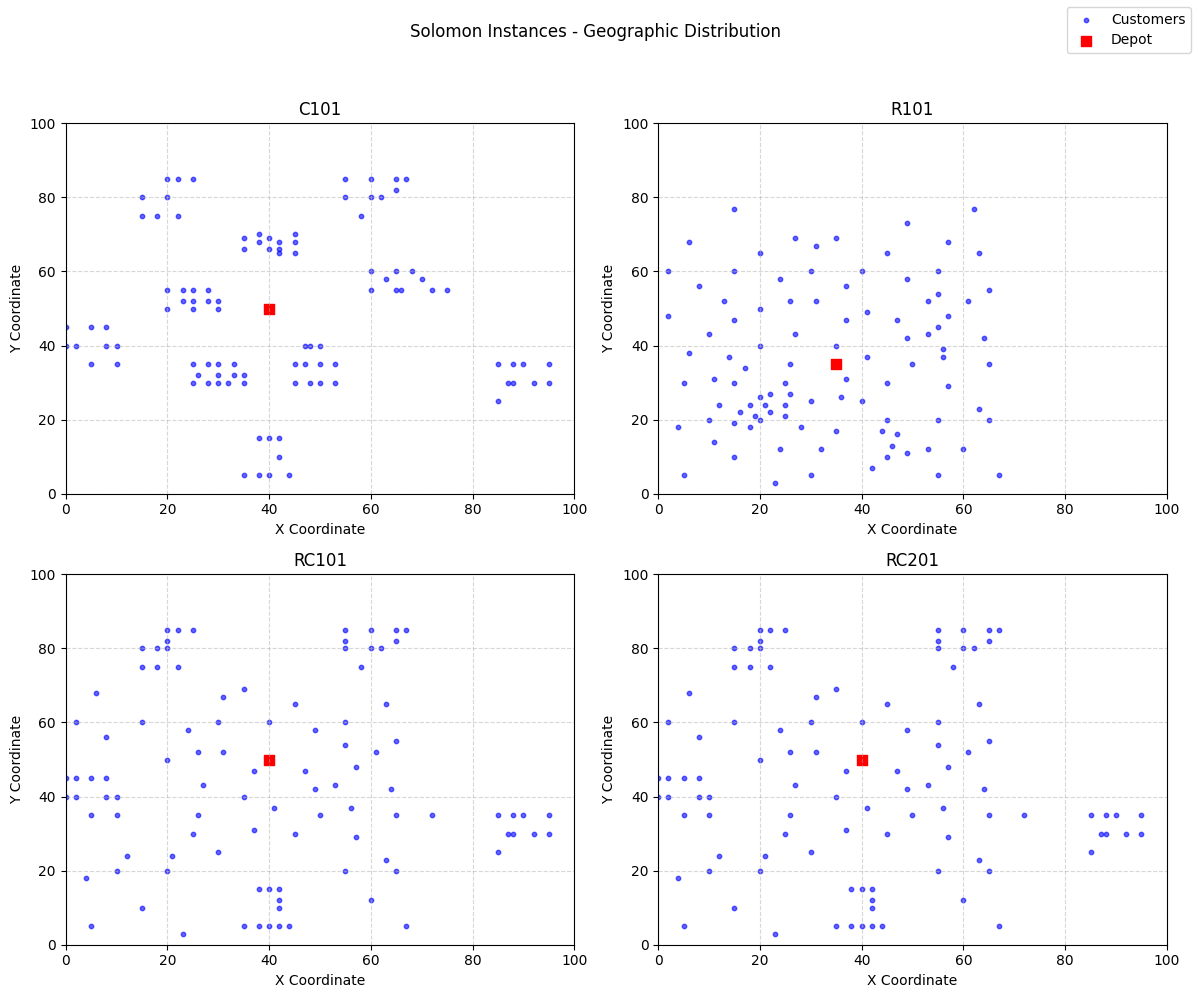

In [3]:
# type hints for better readability and IDE support
axes: np.ndarray
ax: plt.Axes

paths = [
    BASE_PATH / "Datasets" / "C101.txt",
    BASE_PATH / "Datasets" / "R101.txt",
    BASE_PATH / "Datasets" / "RC101.txt",
    BASE_PATH / "Datasets" / "RC201.txt",
]

datasets = [Dataset(p) for p in paths]

avg_window_times = [
    (ds.customers_df['due_date'] - ds.customers_df['ready_time']).mean()
    for ds in datasets
 ]

for ds, avg_time in zip(datasets, avg_window_times):
    logger.info(f"{ds.name} - Average Time Window: {avg_time:.2f}")

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for ax, ds in zip(axes, datasets):
    ax.scatter(ds.customers_df.x[1:], ds.customers_df.y[1:], c='blue', label='Customers', alpha=0.6, s=10)
    ax.scatter(ds.customers_df.x[0], ds.customers_df.y[0], c='red', marker='s', s=60, label='Depot')
    ax.set_title(ds.name)
    ax.set_xlabel("X Coordinate")
    ax.set_ylabel("Y Coordinate")
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)
    ax.grid(True, linestyle='--', alpha=0.5)

for ax in axes[len(datasets):]:
    ax.axis("off")

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right")
fig.suptitle("Solomon Instances - Geographic Distribution")
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Testing base code

Validations for cost function, vizualization methods

2026-02-09 16:56:25,522 [INFO] Feasibility of the solution: Feasible
2026-02-09 16:56:25,523 [INFO] Number of routes in solution: 4
2026-02-09 16:56:25,523 [INFO] Total distance (cost): 1406.94
2026-02-09 16:56:25,525 [INFO] The total cost matches the expected values from literature.


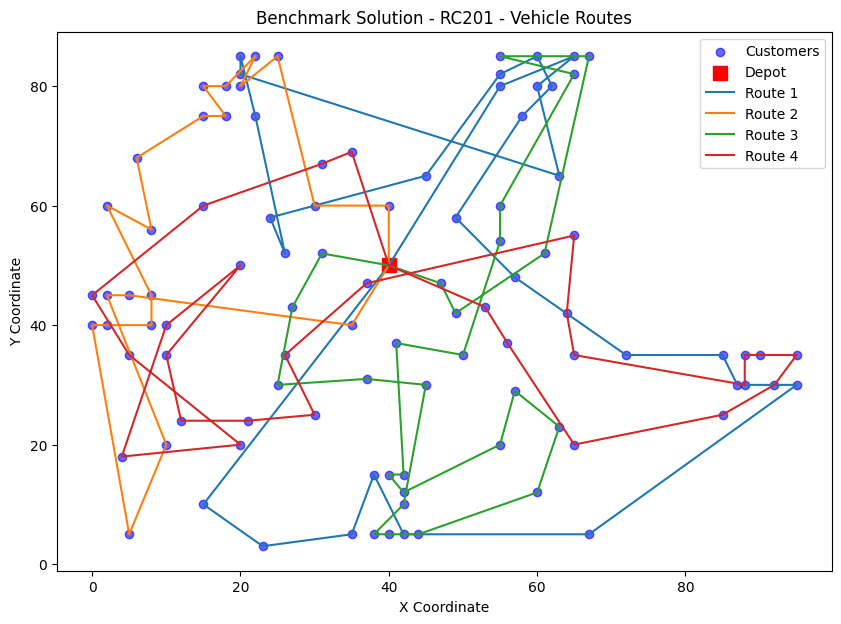

In [4]:
# Read solution and plot routes with cost
solution_path = BASE_PATH / "Solutions" / "rc201.txt"
dataset_path = BASE_PATH / "Datasets" / "rc201.txt"

ds = Dataset(dataset_path)
route = Route(dataset=ds)
route.read_solution(solution_path)

feasibility = route.is_feasible()
total_cost = route.calc_total_distance()
num_subroutes = route.calc_total_vehicles()
total_wait = route.calc_total_waiting_time()
total_service = route.calc_total_service_time()
total_time = route.calc_total_time()

logger.info(f"Feasibility of the solution: {'Feasible' if feasibility else 'Infeasible'}")
logger.info(f"Number of routes in solution: {num_subroutes}")
logger.info(f"Total distance (cost): {total_cost:.2f}")

if (round(total_cost, 2) == 1406.94) and (num_subroutes == 4) and feasibility:
    logger.info("The total cost matches the expected values from literature.")
    # NOTE: This is a validation check to ensure the solution's cost is as expected
    # Check value from literature here: https://www.sintef.no/projectweb/top/vrptw/100-customers/

route.plot_routes('Benchmark Solution - RC201')

# Metaheuristics 

## Simulated Annealing

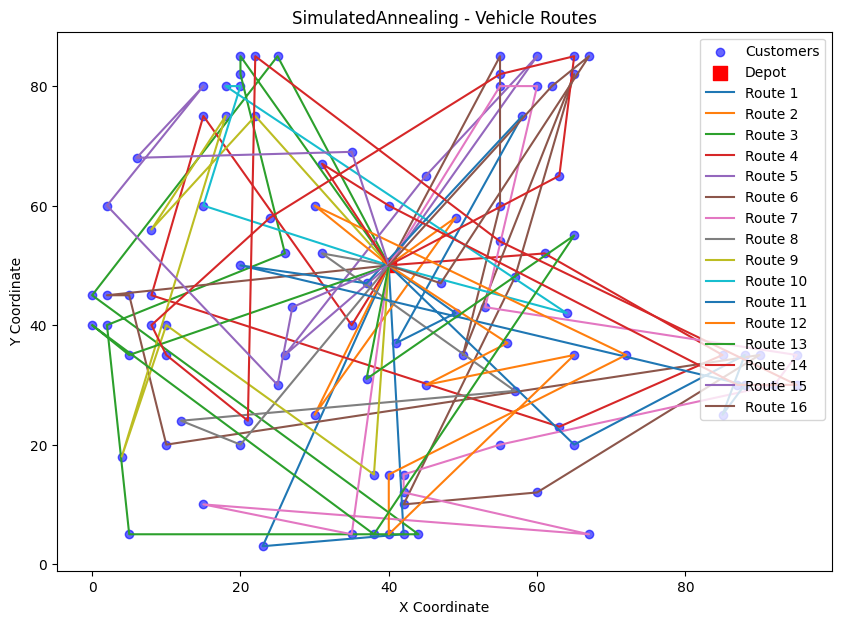

2026-02-09 16:56:54,018 [INFO] SA best solution -> vehicles: 16, distance: 3410.31
2026-02-09 16:56:54,018 [INFO] SA runtime: 28.1623 seconds


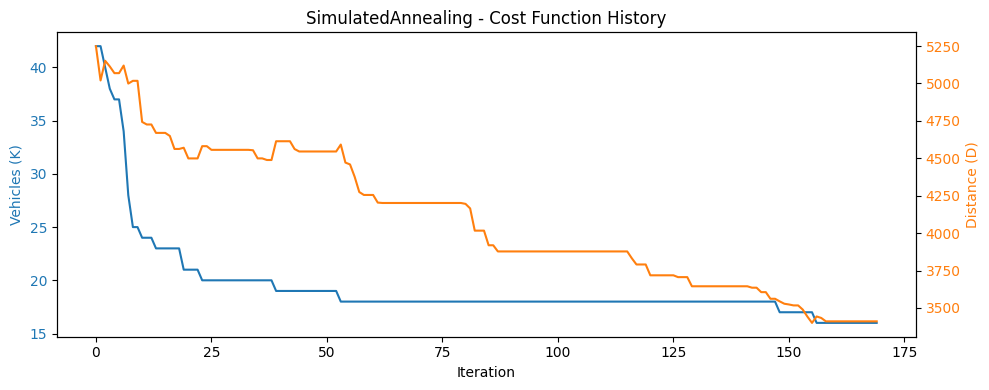

In [5]:
from project.Metaheuristics import SimulatedAnnealing

sa = SimulatedAnnealing(
    dataset=ds,
    initial_temp=300.0,
    cooling_rate=0.98,
    min_temp=10.0,
    iterations_per_temp=20,
    seed=42,
 )

start_time = time.perf_counter()
best_sa = sa.solve()
elapsed_sa = time.perf_counter() - start_time

k_sa, d_sa = best_sa.cost_function()

best_sa.plot_routes('SimulatedAnnealing')

logger.info(f"SA best solution -> vehicles: {k_sa}, distance: {d_sa:.2f}")
logger.info(f"SA runtime: {elapsed_sa:.4f} seconds")
sa.plot_cost_history()

## Tabu Search

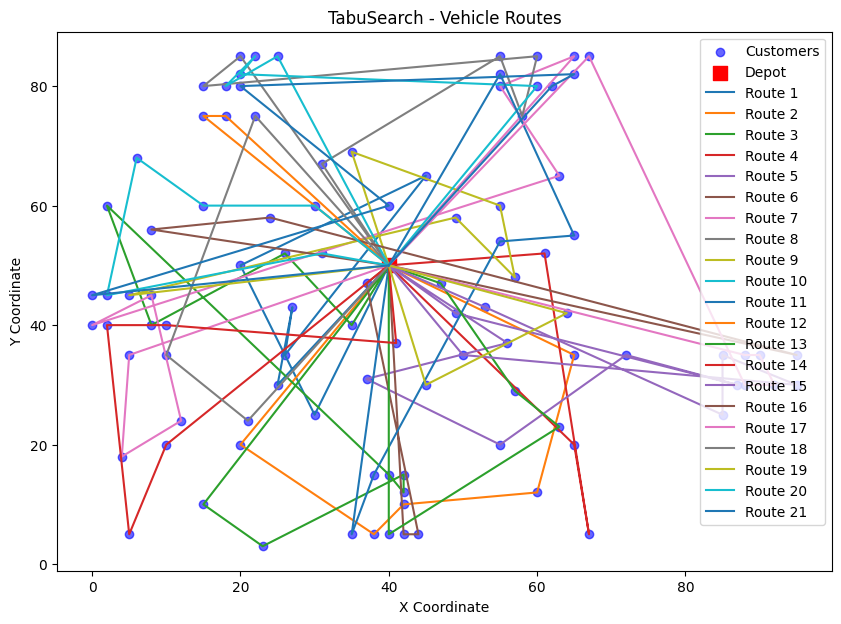

2026-02-09 16:57:23,193 [INFO] TS best solution -> vehicles: 21, distance: 3033.49
2026-02-09 16:57:23,206 [INFO] TS runtime: 28.8104 seconds


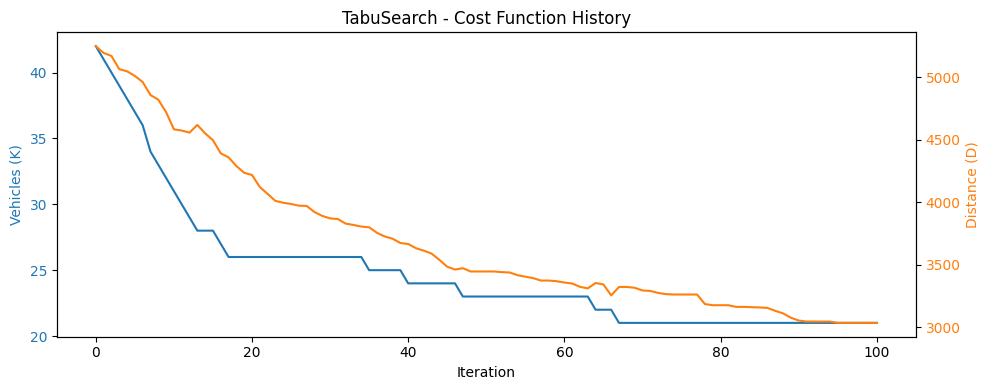

In [6]:
from project.Metaheuristics import TabuSearch

ts = TabuSearch(
    dataset=ds,
    max_iterations=100,
    tabu_tenure=20,
    neighbor_samples=30,
    seed=42,
 )

start_time = time.perf_counter()
best_ts = ts.solve()
elapsed_ts = time.perf_counter() - start_time

k_ts, d_ts = best_ts.cost_function()

best_ts.plot_routes('TabuSearch')

logger.info(f"TS best solution -> vehicles: {k_ts}, distance: {d_ts:.2f}")
logger.info(f"TS runtime: {elapsed_ts:.4f} seconds")
ts.plot_cost_history()

## Genetic Algorithm

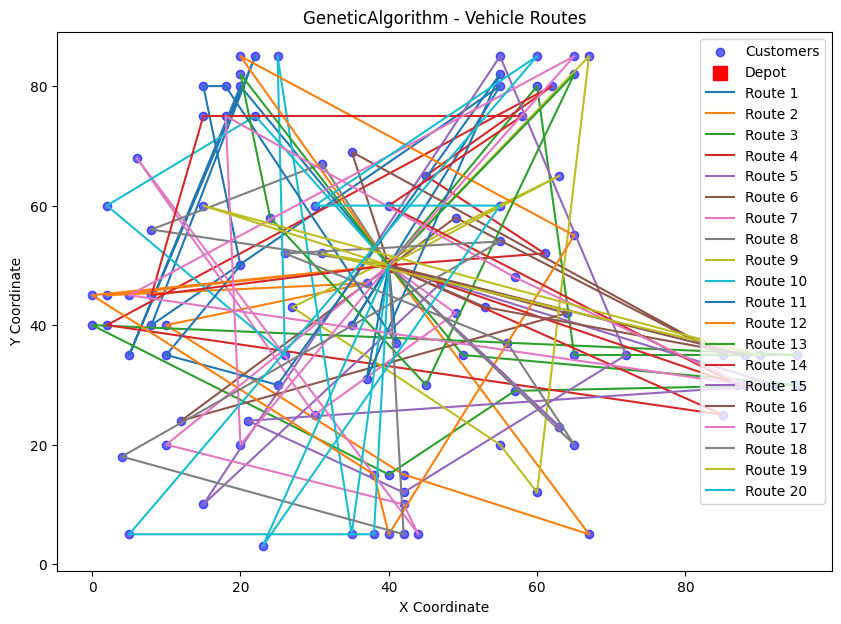

2026-02-09 16:57:57,177 [INFO] GA best solution -> vehicles: 20, distance: 4913.41
2026-02-09 16:57:57,177 [INFO] GA runtime: 33.5791 seconds


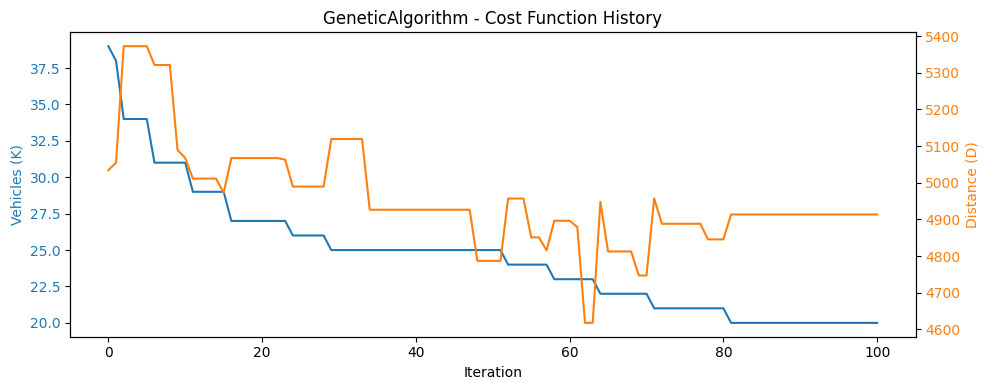

'\n# Plot time components for the best solution\ntravel_time = best.calc_total_distance()\nwaiting_time = best.calc_total_waiting_time()\nservice_time = best.calc_total_service_time()\ntotal_time = best.calc_total_time()\n\nlabels = ["Travel", "Waiting", "Service"]\nvalues = [travel_time, waiting_time, service_time]\n\nplt.figure(figsize=(6, 4))\nplt.bar(labels, values, color=["tab:blue", "tab:orange", "tab:green"])\nplt.title(f"Best Solution Time Components (Total: {total_time:.2f})")\nplt.ylabel("Time")\nplt.tight_layout()\nplt.show()\n'

In [7]:
from project.Metaheuristics import GeneticAlgorithm

ga = GeneticAlgorithm(
    dataset=ds,
    population_size=30,
    generations=100,
    crossover_rate=0.9,
    mutation_rate=0.2,
    seed=42,
 )

start_time = time.perf_counter()
best = ga.solve()
elapsed = time.perf_counter() - start_time

k, d = best.cost_function()

best.plot_routes('GeneticAlgorithm')

logger.info(f"GA best solution -> vehicles: {k}, distance: {d:.2f}")
logger.info(f"GA runtime: {elapsed:.4f} seconds")
ga.plot_cost_history()

'''
# Plot time components for the best solution
travel_time = best.calc_total_distance()
waiting_time = best.calc_total_waiting_time()
service_time = best.calc_total_service_time()
total_time = best.calc_total_time()

labels = ["Travel", "Waiting", "Service"]
values = [travel_time, waiting_time, service_time]

plt.figure(figsize=(6, 4))
plt.bar(labels, values, color=["tab:blue", "tab:orange", "tab:green"])
plt.title(f"Best Solution Time Components (Total: {total_time:.2f})")
plt.ylabel("Time")
plt.tight_layout()
plt.show()
'''



# Multi Agent System

In [ ]:
from project.mesa_model import VRPOptimizationModel

# Mesa multi-agent run
mesa_model = VRPOptimizationModel(ds, pool_size=10, seed=42)
for _ in range(5):
    mesa_model.step()

best_mesa = mesa_model.elite_pool.best()
if best_mesa is not None:
    k_mesa, d_mesa = best_mesa.cost_function()
    best_mesa.plot_routes("Mesa MAS Best")
    logger.info(f"Mesa MAS best -> vehicles: {k_mesa}, distance: {d_mesa:.2f}")

# Appendix

Understanding the size of a NP problem.

Estimates the time required to solve a 100-customer TSP instance using exhaustive search (Brute Force).

In [8]:
import math

num_customers = 100
n_permuted = num_customers - 1 # 1 depot, so we permute (n-1) customers

total_solutions = math.factorial(n_permuted)

solutions_per_ms = 1_000_000_000
solutions_per_sec = solutions_per_ms * 1_000

sec_per_year = 60 * 60 * 24 * 365.25
solutions_per_year = solutions_per_sec * sec_per_year

estimated_years = total_solutions / solutions_per_year

# Contextual comparison: Estimated age of the universe (13.8 billion years)
age_of_universe = 13.8e9
ratio_universe_age = estimated_years / age_of_universe


print(f"\nESTIMATED TIME TO FIND THE OPTIMAL SOLUTION:")
print(f"{estimated_years:.4e} years")

print(f"\nCOMPARISON WITH COSMIC SCALE:")
print(f"This is approximately {ratio_universe_age:.4e} times the age of the universe.")



ESTIMATED TIME TO FIND THE OPTIMAL SOLUTION:
2.9573e+136 years

COMPARISON WITH COSMIC SCALE:
This is approximately 2.1430e+126 times the age of the universe.
